In [16]:
import pandas as pd
import numpy as np
import holidays
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
%matplotlib inline

# Load Data

In [2]:
df=pd.read_csv('test_restaurant.csv',index_col=0,parse_dates=True)
df['Year'] = df.index.year
df['Month'] = df.index.month

# Time Series Analysis

The following graph plots the graph about the number of visitors from 2000 to 2009. <br>
From this graph, it clearly exhibits the seasonality. The number of visitors oscillates between the high and low value on a yearly time scale, corresponding to the month changes over the year.<br>
Also, the mean value of number of visitors is slighly increasing over the year, but the variance almost keeps the same. <br>
I note that there is a few negative value existing, which is invalid in number of visitors data. So I fill the negative value with 0.

C:\Users\li_du\Anaconda3\envs\keras\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


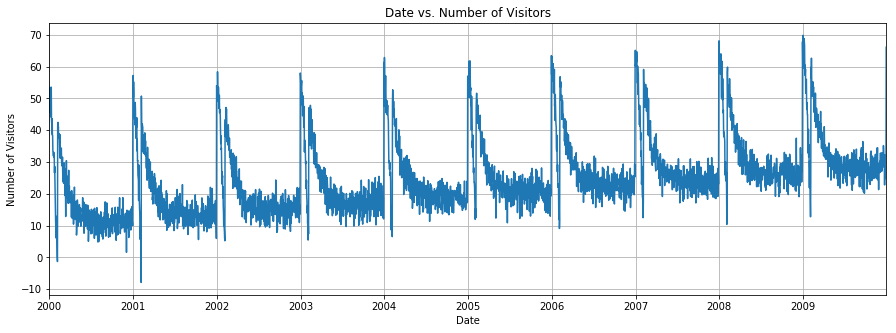

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Date vs. Number of Visitors')
plt.ylabel('Number of Visitors')
plt.xlabel('Date')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['num_visitors'])

Now let's plot the time series in a single year to investigate further. Take year 2000 as an example, now we can clearly see that the high value of number of visitors mostly exist in Janurary and December, while the low value mostly exist in February.

Text(0, 0.5, 'Number of Visitors')

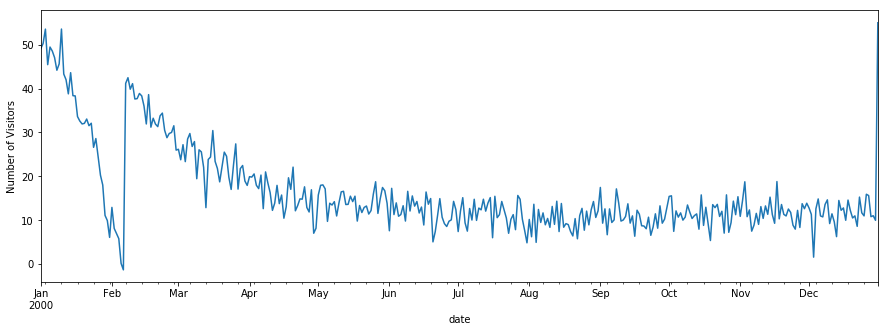

In [4]:
ax = df.loc['2000', 'num_visitors'].plot()
ax.set_ylabel('Number of Visitors')

Also, using seaborn's box plot, I group the 9 years data by month to further prove the the yearly seasonality. Generally, the median value in Janurary is the highest. In December, there exists many extremely high value while in February, there are many extremely low value, which many correspond to the holiday. For other months, the number of visitors does not fluctuate a lot.

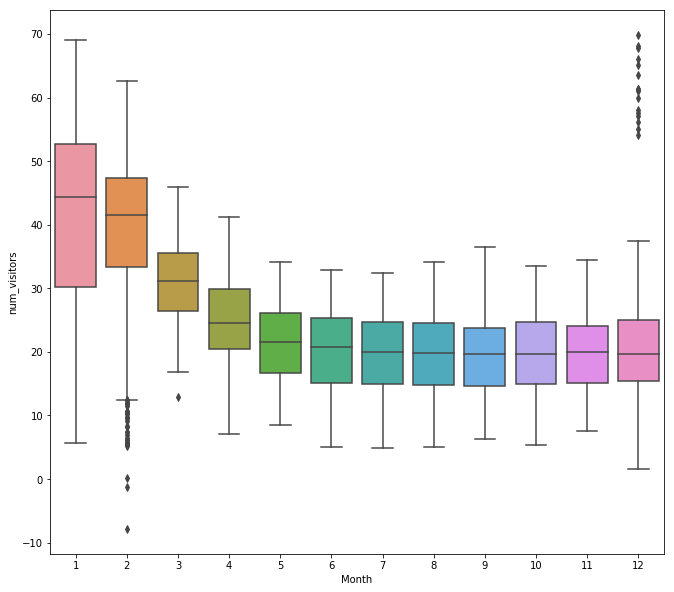

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(11, 10), sharex=True)

sns.boxplot(data=df, x='Month', y='num_visitors')



This plot shows the number of visitors from Janurary to February in 2000. We can see a drastic decreasing in February.

Text(0, 0.5, 'Number of Visitors')

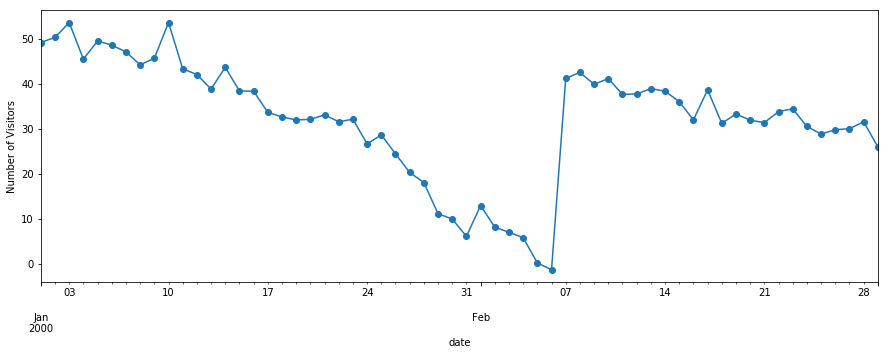

In [6]:
ax = df.loc['2000-01':'2000-02', 'num_visitors'].plot(marker='o', linestyle='-')
ax.set_ylabel('Number of Visitors')

# Feature Engineering

From the time series analysis above, we can conclude that the restaurant data clearly exhibits yearly seasonality and shows the high value in Janurary and December, low value in February, which shows certain relation to the holiday. Also, the average value of number of visitors for each year is slightly increasing while the variance does not change a lot. So I decided to add features "Year", "Month","Weekday","is_holiday" feature to the original data. Also, for the invalid negative value, I replace them with 0. <br>
Because of these features of data, I decided to use LSTM model to train data and predict the number of visitors, which is very accuract for time series forecasting and could learn the seasonality pattern.

In [7]:

# print (df.head())
# print (df.shape)
# print (df.dtypes)
us_holidays = holidays.UnitedStates()
us_holidays = [date for y in range(2000, 2010) for date, _ in sorted(holidays.US(years=y).items())]
# Add columns with year, month, and weekday, week of year, holiday
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
df['week_of_year']=df.index.weekofyear

# fill negative value with 0. 
df[df<0]=0
df['is_holiday'] = np.where(df.index.isin(us_holidays), 1, 0)



# Data Preprocessing

Because my goal is to predict the number of visitors one day forward, which is Dec.30th 2009, I split the data from 2000 to 2008 as train data and the data from 2009 as test data. Finally, I use the last sliding window data to predict the number of visitors on Dec.30th 2009. <br>
Also, I implement the sliding window and normalization to increase model accuracy.

In [8]:
# train test split
train_data=df[:"2007-12-31"]
test_data=df["2008-01-01":]

# extract feature
train_data=pd.DataFrame(train_data,columns=['Year','Month','Weekday','is_holiday','num_visitors'])
test_data=pd.DataFrame(test_data,columns=['Year','Month','Weekday','is_holiday','num_visitors'])
train_data=train_data.to_numpy()
test_data=test_data.to_numpy()

# split features and labels, normalizaion
train_x=train_data[:,:]
train_y=train_data[:,-1]
train_y=train_y.reshape(-1,1)
scaler_1 = MinMaxScaler(feature_range=(0, 1))
scaler_2 = MinMaxScaler(feature_range=(0, 1))
train_x=scaler_1.fit_transform(train_x)
train_y=scaler_2.fit_transform(train_y)
test_x=test_data[:,:]
test_y=test_data[:,-1]
test_y=test_y.reshape(-1,1)
test_x=scaler_1.fit_transform(test_x)
test_y=scaler_2.fit_transform(test_y)
# sliding window size
window_size=14
input_dim=5
def create_inout_sequences(train_x,train_y, tw):
    out_x,out_y = [],[]
    L = len(train_x)
    for i in range(L-tw):
        train_seq = train_x[i:i+tw]
        train_label = train_y[i+tw:i+tw+1]
        out_x.append(train_seq)
        out_y.append(train_label)
       
    return out_x,out_y
out_x,out_y = create_inout_sequences(train_x,train_y, window_size)
out_x=np.array(out_x)
out_y=np.array(out_y)
test_out_x,test_out_y = create_inout_sequences(test_x,test_y, window_size)
test_out_x=np.array(test_out_x)
test_out_y=np.array(test_out_y)

out_y=out_y.reshape(-1)
test_out_y=test_out_y.reshape(-1)

# Model Training

Train on 3274 samples, validate on 349 samples
Epoch 1/15
 - 15s - loss: 0.0372 - acc: 3.0544e-04 - val_loss: 0.0218 - val_acc: 0.0029
Epoch 2/15
 - 14s - loss: 0.0200 - acc: 6.1087e-04 - val_loss: 0.0204 - val_acc: 0.0029
Epoch 3/15
 - 14s - loss: 0.0190 - acc: 6.1087e-04 - val_loss: 0.0195 - val_acc: 0.0029
Epoch 4/15
 - 13s - loss: 0.0179 - acc: 6.1087e-04 - val_loss: 0.0182 - val_acc: 0.0029
Epoch 5/15
 - 13s - loss: 0.0165 - acc: 6.1087e-04 - val_loss: 0.0173 - val_acc: 0.0029
Epoch 6/15
 - 14s - loss: 0.0130 - acc: 6.1087e-04 - val_loss: 0.0193 - val_acc: 0.0029
Epoch 7/15
 - 14s - loss: 0.0075 - acc: 9.1631e-04 - val_loss: 0.0119 - val_acc: 0.0029
Epoch 8/15
 - 14s - loss: 0.0061 - acc: 9.1631e-04 - val_loss: 0.0079 - val_acc: 0.0029
Epoch 9/15
 - 14s - loss: 0.0061 - acc: 9.1631e-04 - val_loss: 0.0074 - val_acc: 0.0029
Epoch 10/15
 - 13s - loss: 0.0059 - acc: 9.1631e-04 - val_loss: 0.0068 - val_acc: 0.0029
Epoch 11/15
 - 14s - loss: 0.0057 - acc: 9.1631e-04 - val_loss: 0.0065 -

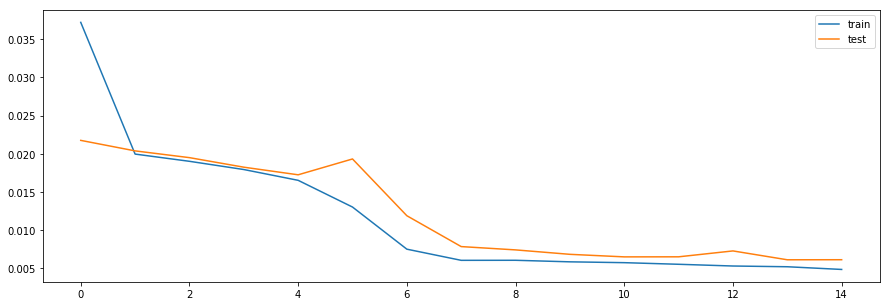

In [9]:
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, input_dim)))

model.add(Dense(16,activation="sigmoid"))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(out_x, out_y, epochs=15, batch_size=4,verbose=2, shuffle=False,validation_data=(test_out_x,test_out_y))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# prediction
prediction_feature=test_x[-window_size:].reshape(1,window_size,input_dim)

res=model.predict(prediction_feature)
test_out_y=test_out_y.reshape(-1,1)
test_out_y=np.concatenate((test_out_y,res))

inv=scaler_2.inverse_transform(test_out_y)
Number_of_visitors_12_30=inv[-1]
print ("Number of visitors on Dec 30th, 2009: ",Number_of_visitors_12_30)

Number of visitors on Dec 30th, 2009:  [45.5003051]


The prediction of number of visitors on Dec 30th,2009 is 45.5

In [22]:
print("The test score RMSE: ",math.sqrt(mean_squared_error(compared,inv_true)))

The test overall RMSE:  4.40003832064071
